---
<div align="center">

# ML2 | Classificação de Sons Urbanos
</div>

---


### Contexto

``Classificação de Sons`` é considerada uma das tarefas mais importantes no campo de **deep learning**. Tem grande impacto em aplicações de **reconhecimento de voz** em assistentes virtuais (como Siri ou Alexa), **atendimento ao cliente**, bem como em **sistemas de recomendação de música e mídia**. Além disso, também influencia na área médica para detectar anomalias em batimentos cardíacos ou sons respiratórios. Além disso, é utilizada em **sistemas de segurança e vigilância** para ajudar a detectar e avaliar possíveis incidentes dentro de uma residência, como pedidos de socorro, disparos ou vidros quebrando. Portanto, nosso objetivo é desenvolver **algoritmos de deep learning** que nos permitam classificar corretamente alguns sons ambientais fornecidos pelo dataset ``UrbanSound8k``.

### Abordagem de Resolução

Utilizando o dataset ``UrbanSound8k`` como nossa fonte principal de dados, pretendemos projetar modelos de deep learning capazes de **identificar**, **prever** e **avaliar** diversos sons comuns em ambientes urbanos, apoiando aplicações em monitoramento de ruído, segurança pública e análise ambiental, permitindo **avaliação precisa** e resposta a eventos sonoros em ambientes urbanos.

### Plano

O projeto inclui várias fases-chave, incluindo:

1. ``Análise Exploratória de Dados``: Começamos analisar o dataset UrbanSound8k para entender melhor sua **estrutura e conteúdo** e a distribuição das classes sonoras.
2. ``Pré-processamento de Dados``: **Limpeza e preparação das amostras de áudio** para garantir consistência e qualidade.
3. ``Engenharia de Features``: Utilizar a biblioteca **Librosa**, extraímos **features relevantes** dos áudios, como as **coeficientes MFCC (Mel-frequency cepstral coefficients)**.
4. ``Definição de Arquitetura de Modelos``: Desenvolvemos arquiteturas de redes neurais adequadas para classificação de som, experimentando diferentes modelos de deep learning.
5. ``Treinamento e Avaliação de Desempenho``: Empregando validação cruzada com 10 folds no dataset pre-particionado para avaliar o desempenho dos modelos usando métricas como acurácia e matrizes de confusão.
6. ``Inferência Estatística``: Realizar uma avaliação estatística das diferenças de desempenho entre os modelos desenvolvidos.

<div align="center">
    
---
## Importar dataset
---

</div>

In [2]:
"""
# TensorFlow 2.15 compatível com Python 3.10
!pip install tensorflow==2.15.0 keras==2.15.0 tensorflow-hub==0.16.1

# Pacotes de suporte
!pip install numpy==1.24.3 pandas==1.5.3 scipy==1.10.1

# Soundata instala automaticamente a versão compatível de librosa
!pip install soundata
"""


'\n# TensorFlow 2.15 compatível com Python 3.10\n!pip install tensorflow==2.15.0 keras==2.15.0 tensorflow-hub==0.16.1\n\n# Pacotes de suporte\n!pip install numpy==1.24.3 pandas==1.5.3 scipy==1.10.1\n\n# Soundata instala automaticamente a versão compatível de librosa\n!pip install soundata\n'

In [3]:

import soundata

dataset = soundata.initialize("urbansound8k", data_home="E:/iacd/3ano/AC2")
print(dataset.data_home)

"""
dataset.download()  # download the dataset
dataset.validate()  # validate that all the expected files are there

example_clip = dataset.choice_clip()  # choose a random example clip
print(example_clip)  # see the available data

"""

E:/iacd/3ano/AC2


'\ndataset.download()  # download the dataset\ndataset.validate()  # validate that all the expected files are there\n\nexample_clip = dataset.choice_clip()  # choose a random example clip\nprint(example_clip)  # see the available data\n\n'

<div align="center">
    
---
## Importar bibliotecas
---

</div>

In [2]:
# Remove Warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import librosa as libr

In [4]:
import tensorflow as tf
from tensorflow.keras.optimizers import (Adam)
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau)
from tensorflow.keras import regularizers
import tensorflow_hub as hub
from scipy.stats import (friedmanchisquare)

from Utils.Configuration import (loadConfig, loadPathsConfig)

from DataPreProcessing.AudioManagement import (loadAudio, showcaseAudio)
from DataPreProcessing.FeatureExtraction import (extractAllRawFeatures, extractRawFeatures1D, extractRawFeatures2D, processRawFeatures, extractMFCCs)
from DataPreProcessing.DataVisualization import (plotFeatureDistribution, plotFeatureDistributionByFold, plotAudioWave, plotAudio1DimensionalFeature, plotChromaFeatures, plotMelSpectrogram, plotSpectralContrast)


In [5]:
import sys
print(sys.executable)

C:\Users\2ndni\anaconda3\envs\tensorflow\python.exe


In [6]:
# Load Configuration Dictionaries
config = loadConfig()
pathsConfig = loadPathsConfig()
config

{'DURATION': 4,
 'SAMPLE_RATE': 44100,
 'HOP_LENGTH': 551,
 'WINDOW_LENGTH': 1014,
 'N_FFT': 1024,
 'TIME_SIZE': 321,
 'N_CHROMA': 12,
 'N_MFCC': 13}

<div align="center">
    
---
## Análise Exploratória de Dados
---

</div>

Nesta fase inicial do projeto, planejamos **revisar e analisar os dados** presentes no dataset UrbanSound8k. Nosso objetivo é obter melhores percepções não apenas sobre os dados disponíveis, mas também sobre **técnicas de processamento eficazes** que nos ajudem a preparar os dados para o treinamento dos modelos.

In [7]:
# Load the dataset metadata
df = pd.read_csv('./UrbanSound8K/metadata/UrbanSound8K.csv')

df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


O dataset fornece principalmente a ``metadata`` sobre as amostras de áudio, incluindo detalhes como o **nome do arquivo** (*slice_file_name*) e os **timestamps de início e fim** (*start* e *end*) no **ID do áudio original** (*fsID*). Além disso, inclui informações sobre o **fold** ao qual cada amostra pertence e o **rótulo** correspondente que a classifica em uma das classes-alvo predefinidas.

Como muito do dataset compreende detalhes técnicos relacionados ao processamento de áudio, nosso foco será analisar a **distribuição dos rótulos alvo no dataset**, uma etapa crucial para entender o **(des)balanceamento de classes** e assegurar que os modelos sejam treinados adequadamente.

## Extração e Pré-processamento dos Dados


---
### Análise e Exploração das Características dos Dados
---


In [8]:
# Load a audio
audioName = '101415-3-0-2.wav'
audioData = loadAudio(df_audio=df, audioSliceName=audioName, audioDuration=config['DURATION'], targetSampleRate=config['SAMPLE_RATE'], usePadding=True)
audioData.shape

(176400,)

In [9]:
# Show the audio associated with the selected file
showcaseAudio(df_audio=df, audioSliceName=audioName)

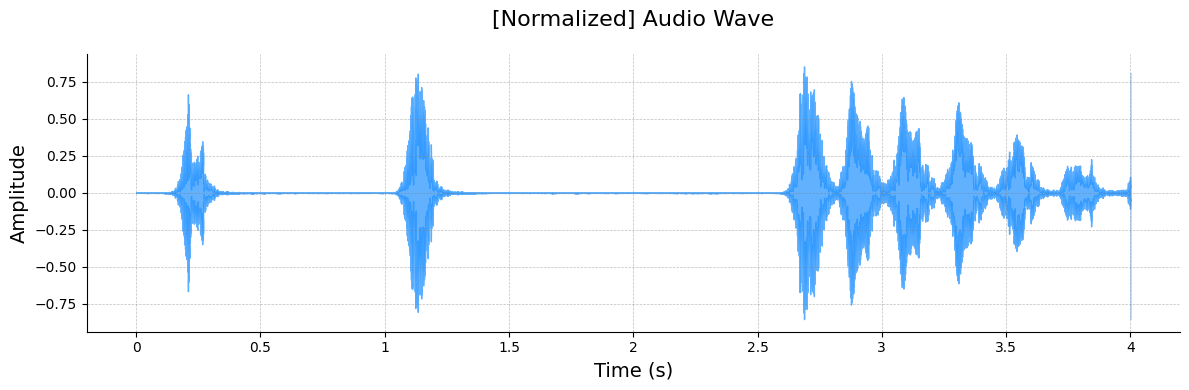

In [10]:
# Plot the Audio Wave
plotAudioWave(df_audio=df, audioSliceName=audioName, config=config)

---
### Características Unidimensionais (1-D)
---

#### &rarr; Zero-Crossing Rate (ZCR)

``Description`` : ZCR measures how **often the signal changes sign** (crosses zero) in a frame.

This is a **time-domain feature** that is particularly useful for **distinguishing between different types of noise or impulsive sounds**, such as car horns or dog barks, which have different temporal behaviors.

In [11]:
# Compute the Audio's Zero Crossing Rate
zeroCrossingRate = libr.feature.zero_crossing_rate(y=audioData)
print(zeroCrossingRate.shape)
# zeroCrossingRate

(1, 345)


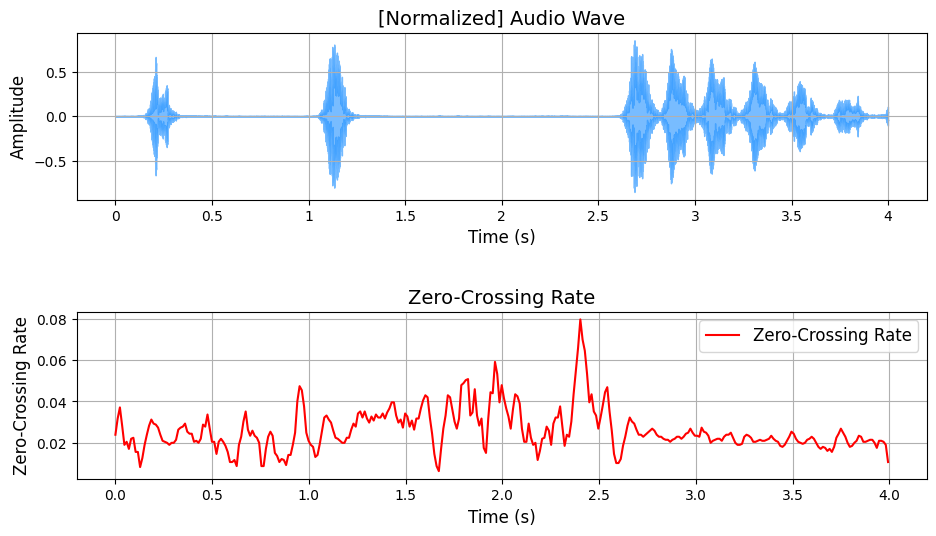

In [12]:
# Plot the Audio's Zero-Crossing Rate
plotAudio1DimensionalFeature(audioData=audioData, extracted1DimensionalFeature=zeroCrossingRate, featureName='Zero-Crossing Rate', yLabel='Zero-Crossing Rate', color='r', config=config)

#### &rarr; Spectral Centroid

``Description`` : The **spectral centroid** is the "center of mass" of the spectrum, giving an indication of **where the energy of the sound is concentrated**.

It helps in **distinguishing between sounds with different frequency content** (e.g., high-pitched sirens vs. low-pitched engine noises).

In [13]:
# Compute the Audio's Spectral Centroid
spectralCentroid = libr.feature.spectral_centroid(y=audioData, sr=config['SAMPLE_RATE'])
print(spectralCentroid.shape)
# spectralCentroid

(1, 345)


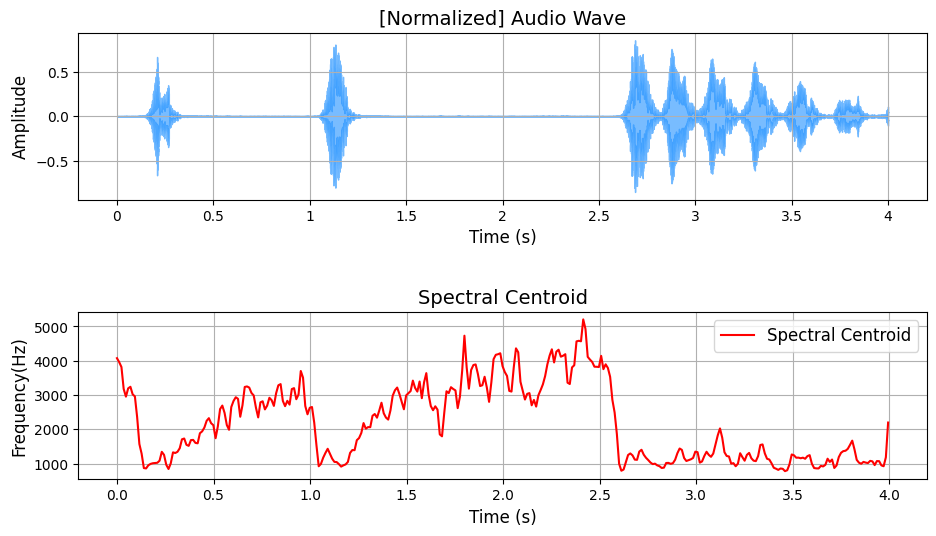

In [14]:
# Plot the Audio's Spectral Centroid
plotAudio1DimensionalFeature(audioData=audioData, extracted1DimensionalFeature=spectralCentroid, featureName='Spectral Centroid', yLabel='Frequency(Hz)', color='r', config=config)

#### &rarr; Spectral Bandwidth

``Description`` : This **measures the width of the spectrum** (the difference between the lower and upper frequencies in a sound).

It helps distinguish sounds with **wide frequency content** (e.g., crowd noise) from those with **narrow frequency content** (e.g., beeps or alarms).

In [15]:
# Compute the Audio's Spectral Bandwidth
spectralBandwidth = libr.feature.spectral_bandwidth(y=audioData, sr=config['SAMPLE_RATE'])
print(spectralBandwidth.shape)
# spectralBandwidth

(1, 345)


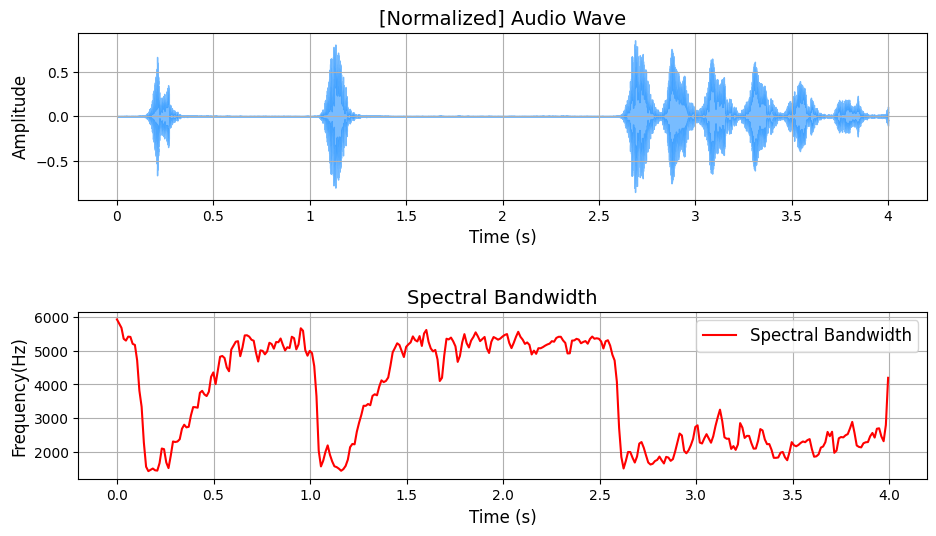

In [16]:
# Plot the Audio's Spectral Bandwidth
plotAudio1DimensionalFeature(audioData=audioData, extracted1DimensionalFeature=spectralBandwidth, featureName='Spectral Bandwidth', yLabel='Frequency(Hz)', color='r', config=config)

#### &rarr; Spectral Flatness

``Description`` : Measures how **noise-like or tonal a sound is by comparing the geometric and arithmetic means of the power spectrum**.

Helps **distinguish between tonal sounds** (e.g., sirens, horns) and **noise-like sounds** (e.g., wind, traffic).

In [17]:
# Compute the Audio's Spectral Flatness
spectralFlatness = libr.feature.spectral_flatness(y=audioData)
print(spectralFlatness.shape)
# spectralFlatness

(1, 345)


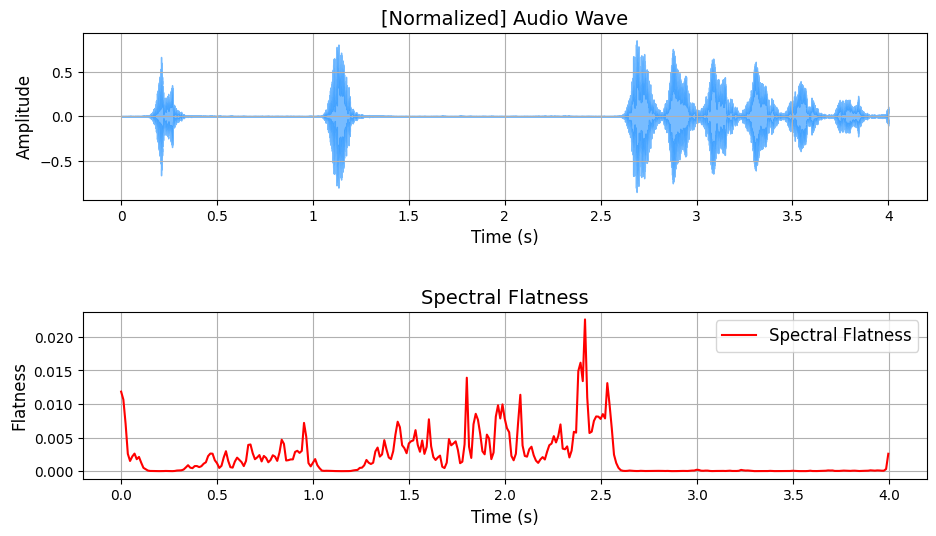

In [18]:
# Plot the Audio's Spectral Flatness
plotAudio1DimensionalFeature(audioData=audioData, extracted1DimensionalFeature=spectralFlatness, featureName='Spectral Flatness', yLabel='Flatness', color='r', config=config)

#### &rarr; Spectral Roll-off

``Description`` : Spectral roll-off is the **frequency below which a specified percentage (usually 85-90%) of the total spectral energy is contained**.

It helps differentiate between**high-frequency sounds** (e.g., sharp noises like sirens or alarms) and **low-frequency ones** (e.g., engine noise, rumbling).

In [19]:
# Compute the Audio's Spectral Roll-off
spectralRolloff = libr.feature.spectral_rolloff(y=audioData, sr=config['SAMPLE_RATE'])
print(spectralRolloff.shape)
# spectralRolloff

(1, 345)


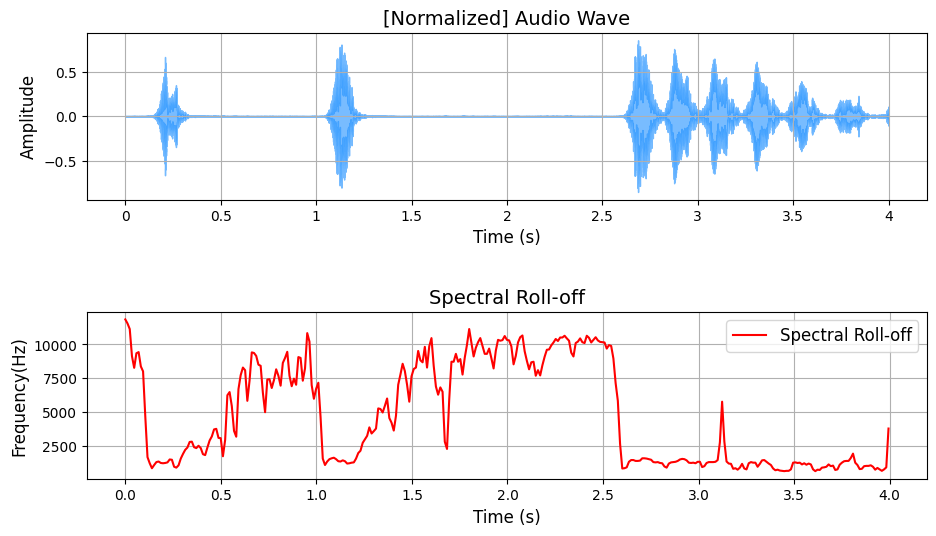

In [20]:
# Plot the Audio's Spectrall Roll-off
plotAudio1DimensionalFeature(audioData=audioData, extracted1DimensionalFeature=spectralRolloff, featureName='Spectral Roll-off', yLabel='Frequency(Hz)', color='r', config=config)

#### &rarr; RMS Energy

``Description`` : The **Root Mean Square (RMS) energy** is a measure of the signal's energy over time.

It is useful to distinguish between **quiet and loud sounds** and can help **classify sounds with varying intensity**, such as traffic or construction noise.

In [21]:
# Compute the Audio's RMS Energy
rms = libr.feature.rms(y=audioData)
print(rms.shape)
# rms

(1, 345)


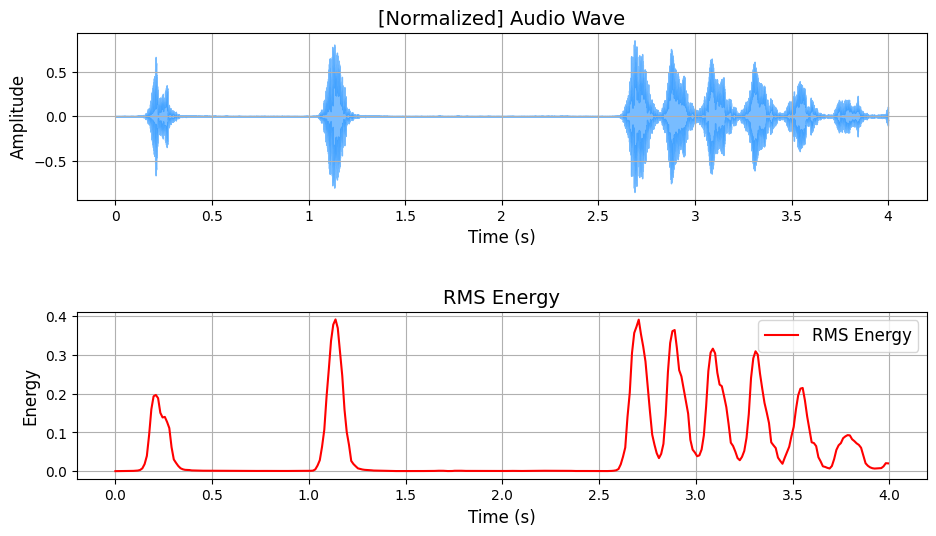

In [22]:
# Plot the Audio's RMS Energy
plotAudio1DimensionalFeature(audioData=audioData, extracted1DimensionalFeature=rms, featureName='RMS Energy', yLabel='Energy', color='r', config=config)

---
### 2-Dimensional Features
---

#### &rarr; Mel-Frequency Cepstral Coefficients (MFCC)

``Description`` : MFCCs represent the **short-term power spectrum of an audio signal**, **emphasizing the perceptually relevant features for human hearing**.

MFCCs are widely used in **audio classification tasks**, including speech recognition and environmental sound classification. They effectively **capture the timbral texture of sounds**, which is important for distinguishing different urban sound categories.

In [23]:
# Compute the MFC Coefficients
mfccs = libr.feature.mfcc(y=audioData, sr=config['SAMPLE_RATE'], n_mfcc=config['N_MFCC'])
print(mfccs.shape)
# mfccs

(13, 345)


#### &rarr; Chroma Features (Chroma STFT)

``Description`` : Chroma features represent the **pitch class (e.g., C, C#, D, etc.)** and are useful for identifying **tonal and harmonic content** in audio.

While **chroma features are traditionally more useful for music**, they can capture **harmonic structure in urban sounds**, especially those with tonal elements like sirens or honking.

In [24]:
# Compute the Chroma Features
chroma_stft = libr.feature.chroma_stft(y=audioData, n_chroma=config['N_CHROMA'], sr=config['SAMPLE_RATE'], n_fft=config['N_FFT'], hop_length=config['HOP_LENGTH'], win_length=config['WINDOW_LENGTH'])
print(chroma_stft.shape)
# chroma_stft

(12, 321)


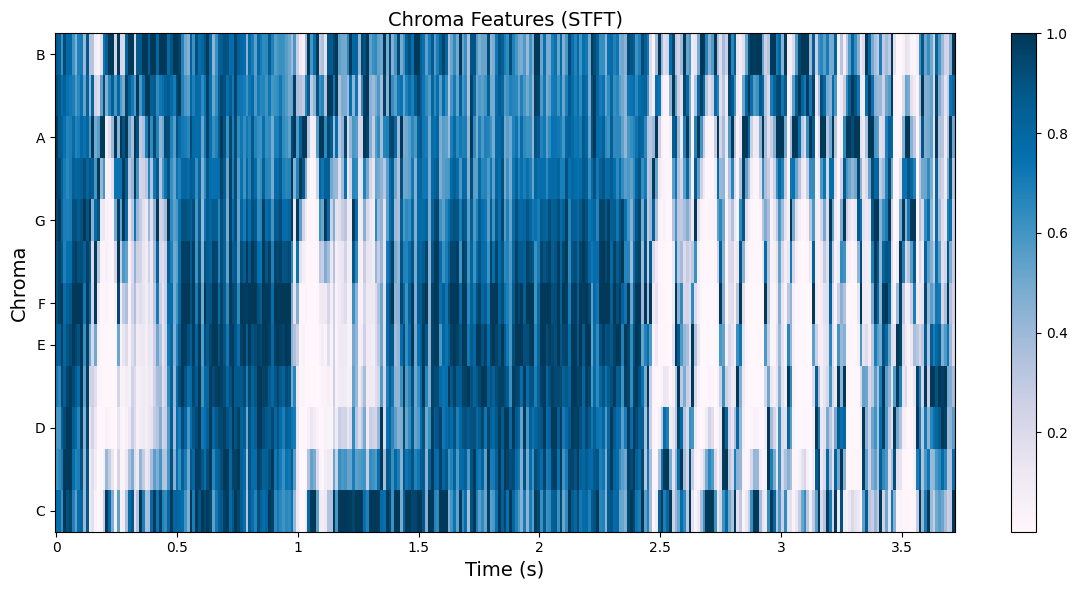

In [25]:
# Plot the audio's Chroma Features
plotChromaFeatures(audioData=audioData, config=config)

#### &rarr; Mel Spectrogram

``Description`` : A Mel spectrogram is a representation of the **signal's power across different frequencies**, scaled to the **Mel scale** (which mimics human auditory perception).

It is particularly useful for **capturing the overall energy and frequency distribution of urban sounds**. It’s a more detailed version of MFCCs, emphasizing the full frequency range.

In [26]:
# Compute the Mel Spectrogram
melSpectrogram = libr.feature.melspectrogram(y=audioData, sr=config['SAMPLE_RATE'])
print(melSpectrogram.shape)
# melSpectrogram

(128, 345)


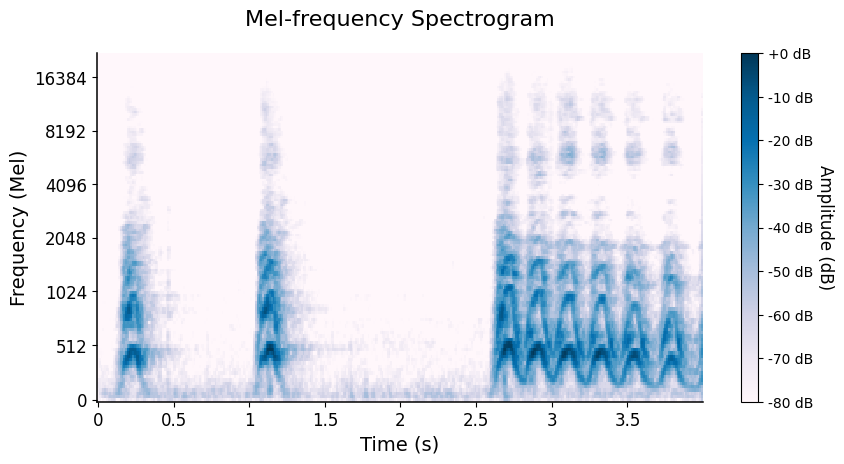

In [27]:
# Plot the Mel Spectrogram
plotMelSpectrogram(audioData, config['SAMPLE_RATE'])

#### &rarr; Spectral Contrast

``Description`` : Spectral contrast measures the **difference between peaks and valleys** in the sound spectrum.

Urban sounds tend to have **diverse spectral profiles** (e.g., the contrast between loud car horns and quieter ambient sounds), making **spectral contrast useful for distinguishing between classes**.

In [28]:
# Compute the Spectral Contrast
spectralContrast = libr.feature.spectral_contrast(y=audioData, sr=config['SAMPLE_RATE'])
print(spectralContrast.shape)
# spectralContrast

(7, 345)


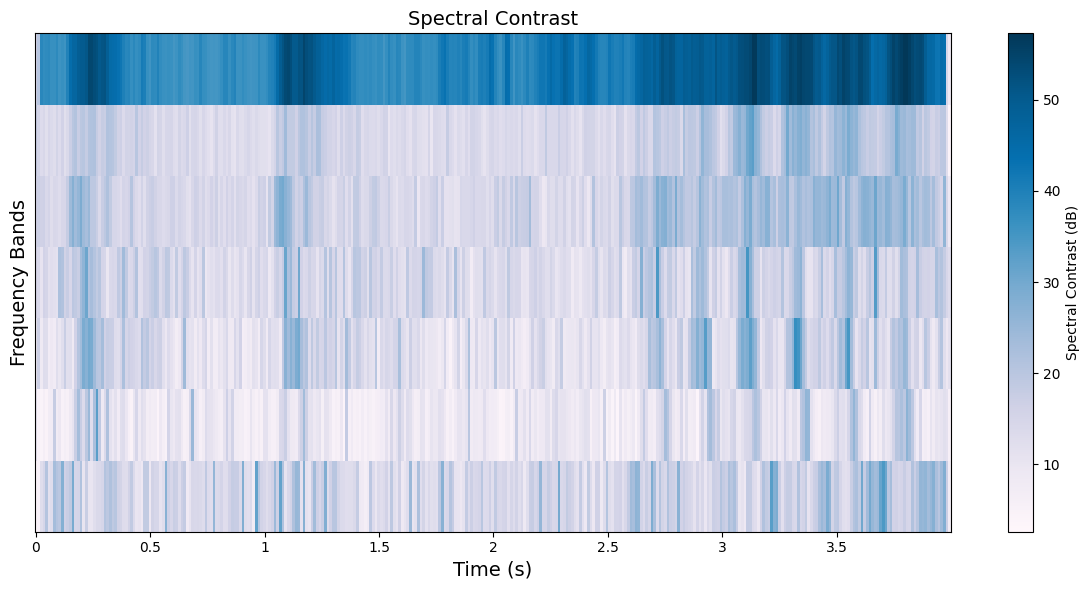

In [29]:
# Plot the Audio's Spectral Contrast
plotSpectralContrast(audioData=audioData, config=config)

---
## Data Extraction and Processing
---

After **evaluating the various features** that can be extracted from the audio samples, we proceeded with their extraction. For simplicity, although **all these features were extracted into respective datasets**, further **processing was selectively applied to some of them**.

We concentrated on the **one-dimensional features**, aiming to **reduce their complexity and dimensionality** while preserving essential information. To achieve this, we **segmented each audio sample into 25-millisecond windows** and calculated the **mean**, **median**, and **standard deviation** for each feature within these windows, resulting in a total of (*DURATION/SEGMENTATION_WINDOW*) **components per feature**.

For the **two-dimensional features**, we focused exclusively on the **Mel-Frequency Cepstral Coefficients (MFCCs) with 13 components**. We extracted both the **raw MFCCs** and processed versions by computing the mean of each MFCC across time. This approach **reduced data dimensionality**, making it more suitable for **training simpler neural networks**.

In [30]:
# Extract all the 1-Dimensional and 2-Dimensional Features on each Fold
for fold in range(1, 11):

    print(f"[CURRENT] Fold {fold}")
    
    # Extract all Raw Features
    extractAllRawFeatures(audio_df=df, fold=fold, config=config, pathsConfig=pathsConfig)

    # Extract and process 1-Dimensional Features
    extractRawFeatures1D(audio_df=df, fold=fold, config=config, pathsConfig=pathsConfig)
    processRawFeatures(fold=fold, intervalStep=20, featuresDimensionality="1D", pathsConfig=pathsConfig)
    
    # Extract and process 2-Dimensional Features
    extractRawFeatures2D(audio_df=df, fold=fold, config=config, pathsConfig=pathsConfig)
    processRawFeatures(fold=fold, intervalStep=20, featuresDimensionality="2D", pathsConfig=pathsConfig)

    # Extract the MFCCs (Raw and their mean based on the coefficients)
    extractMFCCs(audio_df=df, raw=True, fold=fold, config=config, pathsConfig=pathsConfig)
    extractMFCCs(audio_df=df, raw=False, fold=fold, config=config, pathsConfig=pathsConfig)

    print(f"[Fold {fold}] Finished Extraction and Processessing")

[CURRENT] Fold 1
[Fold 1] Finished Extraction and Processessing
[CURRENT] Fold 2
[Fold 2] Finished Extraction and Processessing
[CURRENT] Fold 3
[Fold 3] Finished Extraction and Processessing
[CURRENT] Fold 4
[Fold 4] Finished Extraction and Processessing
[CURRENT] Fold 5
[Fold 5] Finished Extraction and Processessing
[CURRENT] Fold 6
[Fold 6] Finished Extraction and Processessing
[CURRENT] Fold 7
[Fold 7] Finished Extraction and Processessing
[CURRENT] Fold 8
[Fold 8] Finished Extraction and Processessing
[CURRENT] Fold 9
[Fold 9] Finished Extraction and Processessing
[CURRENT] Fold 10
[Fold 10] Finished Extraction and Processessing


<div align="center">
    
---
## Model Architecture - Development and Evaluation
---

</div>

In this phase of the project, we aim to **design, implement, and evaluate** various neural network architectures, assessing their **ability to generalize effectively** across the UrbanSound8k dataset using the previously extracted features.

---
### Managing Training Data
---

We started by examining how the data is **organized across the 10 folds** to better understand how to **manage and utilize it effectively**. Given that the evaluation of the models requires a **10-Fold Cross-Validation methodology**, we implemented a systematic approach: **designating one fold as the test set**, the **next fold as the validation set**, and using the **remaining folds for training**, which aligns with the **proposed split and evaluation techniques** described in the **Assignment Paper**.

---
### Architecture Selection (Temos que escolher as redes neuronais)
---

As part of the **assignment requirements**, we will **design and evaluate multiple neural network architectures** to assess their **generalization performance on the UrbanSound8k dataset**. Specifically, we will develop and test the following **network** types:

- ``Multi-Layer Perceptron (MLP)`` &rarr; A **feedforward network**.
  
- ``Convolutional Neural Networks (CNN)`` &rarr; Both standalone **CNN architectures** and those leveraging **transfer learning**, utilizing the **pre-trained YAMNet neural network** on the extracted data.

- ``Residual Neural Network (ResNet)`` &rarr; A architecture employing **residual connections**.

---
### Training Strategies
---

To evaluate these architectures, we plan to perform a **10-fold cross-validation by rotating the training, validation, and test sets across all available folds of the dataset**. This approach ensures that the model's performance is **assessed on the entire UrbanSound8k dataset** rather than just a single fold, providing a **more robust and reliable evaluation** of its generalization capabilities.

In addition, we will utilize **two key callbacks** during the model's training process to enhance efficiency and optimize performance:

- ``Early Stopping`` &rarr; Monitors the model's performance on a validation set and **stops training when improvements plateau**, **preventing overfitting** and conserving computational resources that would otherwise be spent on non-significant gains.
  
- ``Reduce Learning Rate on Platea`` &rarr; By **reducing the learning rate when the model's performance stops improving**, this callback allows the **optimizer to make better adjustments as it gets closer to the minimum of the loss function**, which promotes a better convergence, leading towards a **better model accuracy**.

In [32]:
# Define callbacks
def callbacks():
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        min_delta=5e-4,
        patience=10,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=10,
        min_lr=1e-5
    )

    return [early_stopping, reduce_lr]